**Промышленность**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from scipy.stats import randint
import warnings
warnings.filterwarnings("ignore")

# Шаг 1. Загрузка данных

In [3]:
try:
    df_arc = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=[1, 2])
    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates=list(pd.read_csv('/datasets/data_bulk_time_new.csv').columns[1:]))
    df_gas = pd.read_csv('/datasets/data_gas_new.csv')
    df_temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=[1])
    df_wire = pd.read_csv('/datasets/data_wire_new.csv')
    df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates=list(pd.read_csv('/datasets/data_wire_time_new.csv').columns[1:]))
except:
    df_arc = pd.read_csv('data_arc_new.csv', parse_dates=[1, 2])
    df_bulk = pd.read_csv('data_bulk_new.csv')
    df_bulk_time = pd.read_csv('data_bulk_time_new.csv', parse_dates=list(pd.read_csv('data_bulk_time_new.csv').columns[1:]))
    df_gas = pd.read_csv('data_gas_new.csv')
    df_temp = pd.read_csv('data_temp_new.csv', parse_dates=[1])
    df_wire = pd.read_csv('data_wire_new.csv')
    df_wire_time = pd.read_csv('data_wire_time_new.csv', parse_dates=list(pd.read_csv('data_wire_time_new.csv').columns[1:]))

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [6]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [7]:
df_arc['key'].nunique()

3214

In [8]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [9]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
df_bulk['key'].nunique()

3129

In [11]:
df_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-09-06 11:54:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:49:45,NaT,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaT,NaT,2019-09-06 12:26:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,NaT,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34


In [12]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [13]:
df_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [14]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [15]:
df_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [16]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [17]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [19]:
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [20]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


В ходе первичного осмотра данных после загрузки выявлено, что во всех 7 датасетах есть 1 общий столбец с номером партии, датасеты различны по размерам, в большинстве из них присутствуют пропуски значений. Формат данных для дат исправлен на datetime64.

# Шаг 2. Исследовательский анализ и предобработка данных

## Данные об электродах

In [21]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [22]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


В глаза сразу бросается отрицательное значение для реактивной мощности -715. Рассмотрим строку подробнее

In [23]:
df_arc[df_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [24]:
# Удалим строку с явным выбросом, поскольку отрицательной мощности быть не может
df_arc = df_arc.loc[df_arc['Реактивная мощность'] >= 0]

In [25]:
# Создадим новые признаки: время нагрева дугой и полную мощность
df_arc['Время нагрева дугой'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
df_arc['Время нагрева дугой'] = df_arc['Время нагрева дугой'].dt.total_seconds().astype('int')
df_arc['Общая мощность'] = (df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)**0.5
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой,Общая мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934
...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157,0.532085
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180,0.792429
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184,1.293389
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57,0.641792


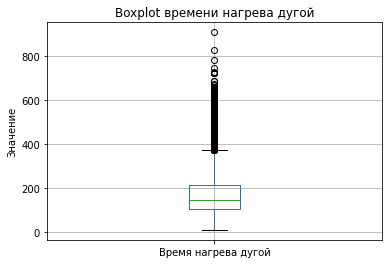

In [26]:
df_arc.boxplot(column='Время нагрева дугой')
plt.title('Boxplot времени нагрева дугой')
plt.ylabel('Значение')
plt.show()

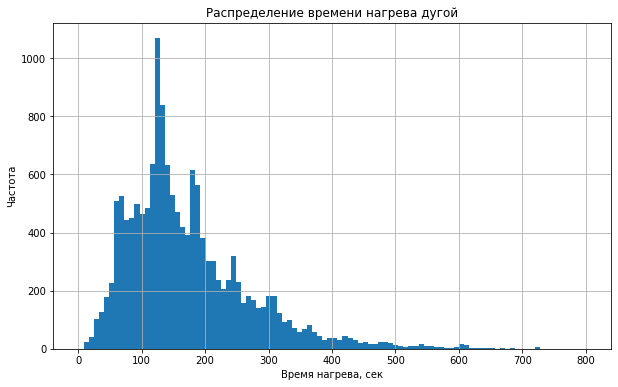

In [27]:
plt.figure(figsize=(10,6))
df_arc['Время нагрева дугой'].hist(bins=100,range=(1,800))
plt.title('Распределение времени нагрева дугой')
plt.xlabel('Время нагрева, сек')
plt.ylabel('Частота')
plt.show()

In [28]:
df_arc['Время нагрева дугой'].describe()

count    14875.000000
mean       171.675160
std         98.188759
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: Время нагрева дугой, dtype: float64

Минимальное значение времени нагрева составляет 11 секунд, а максимальное около 15 минут. Оставим данные без изменений, поскольку диапазон времени нагрева выглядит адекватно.

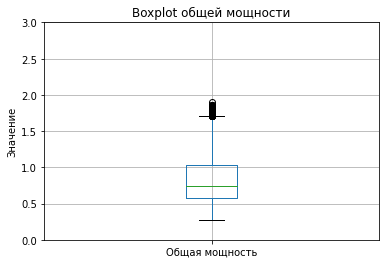

In [29]:
df_arc.boxplot(column='Общая мощность')
plt.title('Boxplot общей мощности')
plt.ylabel('Значение')
plt.ylim(0, 3)
plt.show()

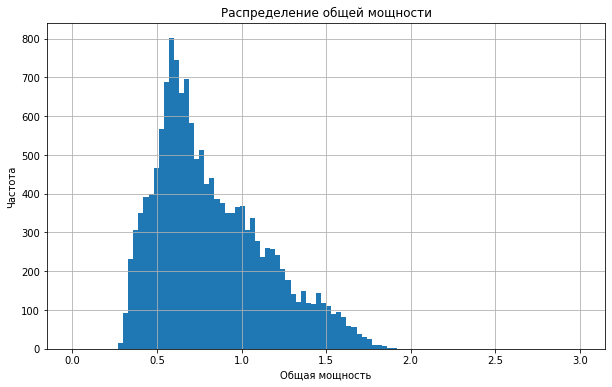

In [30]:
plt.figure(figsize=(10,6))
df_arc['Общая мощность'].hist(bins=100,range=(0,3))
plt.title('Распределение общей мощности')
plt.xlabel('Общая мощность')
plt.ylabel('Частота')
plt.show()

In [31]:
df_arc['Общая мощность'].describe()

count    14875.000000
mean         0.823385
std          0.323470
min          0.275718
25%          0.578839
50%          0.746554
75%          1.030402
max          1.898158
Name: Общая мощность, dtype: float64

Значения для общей мощности выглядят как адекватные

Далее необходимо сгруппировать данные по столбцу key (ковш)

In [32]:
df_arc_grouped = df_arc.groupby('key').mean()
df_arc_grouped

,Активная мощность,Реактивная мощность,Время нагрева дугой,Общая мощность
key,,,,
1,0.607346,0.428564,219.60,0.743747
2,0.534852,0.363339,202.75,0.647087
3,0.812728,0.587491,131.00,1.003845
4,0.676622,0.514248,185.25,0.850010
5,0.563238,0.421998,217.25,0.704245
...,...,...,...,...
3237,0.508374,0.405083,181.80,0.650131
3238,0.458274,0.346034,182.00,0.574646
3239,0.606001,0.442693,152.00,0.751810


## Данные о подаче сыпучих материалов (объём)

In [33]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [34]:
# Согласно вводным по пайплайну обработки стали, в ковш с металлом подают различные сыпучие материалы в различном объеме, т.е. NaN означает отсутствие сыпучего матераила данного состава.
# Таким образом, заменяем все NaN на 0
df_bulk.fillna(0, inplace=True)
df_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


## Данные о подаче сыпучих материалов (время)

In [35]:
df_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-09-06 11:54:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:49:45,NaT,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaT,NaT,2019-09-06 12:26:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,NaT,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34


Для построения модели данные о времени подачи сыпучих метериалов не нужны. 

## Данные о продувке сплава газом

In [36]:
df_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [37]:
df_gas.value_counts()

key   Газ 1    
1     29.749986    1
2166  24.198770    1
2156  8.061703     1
2157  7.698340     1
2158  8.121759     1
                  ..
1086  12.067864    1
1087  12.118154    1
1088  16.937201    1
1089  8.559027     1
3241  12.680959    1
Length: 3239, dtype: int64

В таблице с объемом подаваемого газа нет пропусков и каждому ковшу соответствует 1 значение объема.

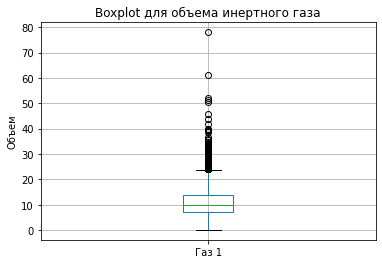

In [38]:
df_gas.boxplot(column='Газ 1')
plt.title('Boxplot для объема инертного газа')
plt.ylabel('Объем')
plt.show()

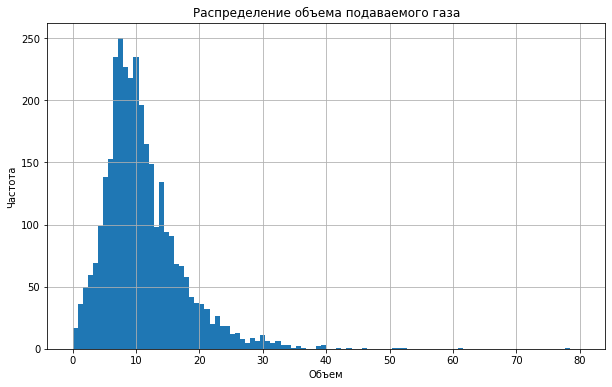

In [39]:
plt.figure(figsize=(10,6))
df_gas['Газ 1'].hist(bins=100,range=(0,80))
plt.title('Распределение объема подаваемого газа')
plt.xlabel('Объем')
plt.ylabel('Частота')
plt.show()

In [40]:
df_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

Считаю, что не нужно удалять выбросы межквартильным методом, поскольку так мы потеряем существенную часть ковшей из выборки. Данные без критических выбросов.

## Результаты измерения температуры

In [41]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [42]:
# Удалим строки, где отсутствует целевой признак
df_temp.dropna(inplace=True)
df_temp.shape[0]

14665

In [43]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18061,3237,2019-09-06 11:31:15,1569.0
18067,3238,2019-09-06 12:16:15,1584.0
18071,3239,2019-09-06 14:16:50,1598.0
18080,3240,2019-09-06 15:25:21,1617.0


In [44]:
df_temp = df_temp.rename(columns={'Время замера':'measure_time'})
# Найдем индексы строк с самой поздней датой для каждого уникального ковша
latest_indices = df_temp.groupby(['key']).idxmax()['measure_time']

# найдем для каждого ковша последний замер температуры сплава
latest_temp = df_temp.loc[latest_indices]
latest_temp.reset_index(drop=True, inplace=True)
latest_temp

,key,measure_time,Температура
0,1,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:36:39,1602.0
...,...,...,...
3211,3237,2019-09-06 11:31:15,1569.0
3212,3238,2019-09-06 12:16:15,1584.0
3213,3239,2019-09-06 14:16:50,1598.0
3214,3240,2019-09-06 15:25:21,1617.0


In [45]:
# Найдем индексы строк с самой ранней датой для каждого уникального ковша
early_indices = df_temp.groupby(['key']).idxmin()['measure_time']

# найдем для каждого ковша начальный замер температуры сплава
beginning_temp = df_temp.loc[early_indices]
beginning_temp.reset_index(drop=True, inplace=True)
beginning_temp = beginning_temp.rename(columns={'Температура':'begin_temp'})

In [46]:
df_temperature = pd.merge(latest_temp, beginning_temp, on='key', how='inner')
df_temperature = df_temperature.rename(columns={'Температура':'end_temp'})
df_temperature

,key,measure_time_x,end_temp,measure_time_y,begin_temp
0,1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0
1,2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0
2,3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0
3,4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0
4,5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0
...,...,...,...,...,...
3211,3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:31:15,1569.0
3212,3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:16:15,1584.0
3213,3239,2019-09-06 14:16:50,1598.0,2019-09-06 14:16:50,1598.0
3214,3240,2019-09-06 15:25:21,1617.0,2019-09-06 15:25:21,1617.0


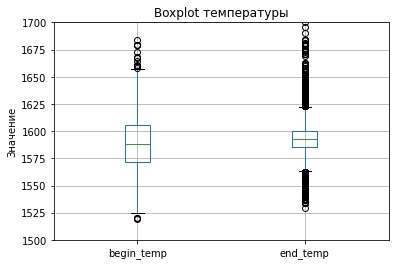

In [47]:
df_temperature.boxplot(column=['begin_temp', 'end_temp'])
plt.title('Boxplot температуры')
plt.ylabel('Значение')
plt.ylim(1500, 1700)
plt.show()

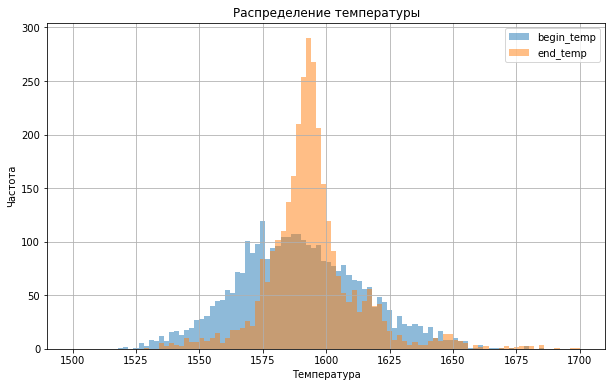

In [48]:
plt.figure(figsize=(10,6))
df_temperature['begin_temp'].hist(bins=100,range=(1500,1700), alpha=0.5, legend=True)
df_temperature['end_temp'].hist(bins=100,range=(1500,1700), alpha=0.5, legend=True)
plt.title('Распределение температуры')
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.show()

In [49]:
df_temperature.describe()

,key,end_temp,begin_temp
count,3216.000000,3216.000000,3216.000000
mean,1622.199316,1593.928483,1588.592040
std,935.088523,19.874627,29.137454
min,1.000000,1204.000000,1191.000000
25%,815.750000,1585.000000,1572.000000
50%,1622.500000,1593.000000,1588.000000
75%,2431.250000,1600.000000,1606.000000
max,3241.000000,1700.000000,1684.000000


Согласно википедии температура плавления стали варьируется в диапазоне 1450-1520 градусов, т.е. все значения ниже 1450 для конечной температуры являются выбросами. Касаемо значений температур выше 1520, то они имеют место быть и возможно отражают важные производственные процессы. 

In [50]:
df_temperature[df_temperature['end_temp'] < 1450]

,key,measure_time_x,end_temp,measure_time_y,begin_temp
2538,2561,2019-08-12 18:49:29,1204.0,2019-08-12 18:49:29,1204.0


In [51]:
df_temperature = df_temperature.query('end_temp >= 1450')
df_temperature.describe()

,key,end_temp,begin_temp
count,3215.000000,3215.000000,3215.000000
mean,1621.907309,1594.049767,1588.711664
std,935.087320,18.649454,28.341140
min,1.000000,1529.000000,1191.000000
25%,815.500000,1585.000000,1572.000000
50%,1622.000000,1593.000000,1588.000000
75%,2430.500000,1600.000000,1606.000000
max,3241.000000,1700.000000,1684.000000


Распределения температур выглядит как нормальное, у конечной температуры распределение имеет меньший диапазон, чем у начальной температуры. Аномальных выбросы обработаны.

## Данные о проволочных материалах (объём)

In [52]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Заменим пропущенные значения на 0
df_wire.fillna(0, inplace=True)

## Данные о проволочных материалах (время)

In [54]:
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Также как и данные о времени подачи сыпучих материалов, данные о времени добавления проволочных материалов не нужны для создания модели.

# Шаг 3. Объединение данных

Объединять данные будем с помощью метода merge(), тип объединения будет outer для исключения потерь данных.

In [55]:
df = df_arc_grouped.merge(df_bulk, on='key', how='inner')

In [56]:
df = pd.merge(df, df_gas, on='key', how='inner')
df

,key,Активная мощность,Реактивная мощность,Время нагрева дугой,Общая мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,0.607346,0.428564,219.60,0.743747,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,0.534852,0.363339,202.75,0.647087,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,0.812728,0.587491,131.00,1.003845,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,0.676622,0.514248,185.25,0.850010,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,0.563238,0.421998,217.25,0.704245,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121,3237,0.508374,0.405083,181.80,0.650131,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905
3122,3238,0.458274,0.346034,182.00,0.574646,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669
3123,3239,0.606001,0.442693,152.00,0.751810,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518
3124,3240,0.663536,0.474710,167.80,0.816584,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,11.863103


In [57]:
df = pd.merge(df, df_temperature, on='key', how='inner')
df

,key,Активная мощность,Реактивная мощность,Время нагрева дугой,Общая мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,measure_time_x,end_temp,measure_time_y,begin_temp
0,1,0.607346,0.428564,219.60,0.743747,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0
1,2,0.534852,0.363339,202.75,0.647087,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0
2,3,0.812728,0.587491,131.00,1.003845,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0
3,4,0.676622,0.514248,185.25,0.850010,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0
4,5,0.563238,0.421998,217.25,0.704245,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,3237,0.508374,0.405083,181.80,0.650131,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905,2019-09-06 11:31:15,1569.0,2019-09-06 11:31:15,1569.0
3121,3238,0.458274,0.346034,182.00,0.574646,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669,2019-09-06 12:16:15,1584.0,2019-09-06 12:16:15,1584.0
3122,3239,0.606001,0.442693,152.00,0.751810,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518,2019-09-06 14:16:50,1598.0,2019-09-06 14:16:50,1598.0
3123,3240,0.663536,0.474710,167.80,0.816584,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,11.863103,2019-09-06 15:25:21,1617.0,2019-09-06 15:25:21,1617.0


In [58]:
df = pd.merge(df, df_wire, on='key', how='inner')
df

,key,Активная мощность,Реактивная мощность,Время нагрева дугой,Общая мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,measure_time_x,end_temp,measure_time_y,begin_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,0.607346,0.428564,219.60,0.743747,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.534852,0.363339,202.75,0.647087,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.812728,0.587491,131.00,1.003845,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.676622,0.514248,185.25,0.850010,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.563238,0.421998,217.25,0.704245,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,3237,0.508374,0.405083,181.80,0.650131,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905,2019-09-06 11:31:15,1569.0,2019-09-06 11:31:15,1569.0,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3017,3238,0.458274,0.346034,182.00,0.574646,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669,2019-09-06 12:16:15,1584.0,2019-09-06 12:16:15,1584.0,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3018,3239,0.606001,0.442693,152.00,0.751810,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518,2019-09-06 14:16:50,1598.0,2019-09-06 14:16:50,1598.0,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3019,3240,0.663536,0.474710,167.80,0.816584,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,11.863103,2019-09-06 15:25:21,1617.0,2019-09-06 15:25:21,1617.0,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# делаем столбец key индексом в новом датафрейме
df = df.set_index('key')
display(df.head())
df.info()

,Активная мощность,Реактивная мощность,Время нагрева дугой,Общая мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,measure_time_x,end_temp,measure_time_y,begin_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.607346,0.428564,219.60,0.743747,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.534852,0.363339,202.75,0.647087,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.812728,0.587491,131.00,1.003845,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.676622,0.514248,185.25,0.850010,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.563238,0.421998,217.25,0.704245,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3021 entries, 1 to 3241
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Активная мощность    3021 non-null   float64       
 1   Реактивная мощность  3021 non-null   float64       
 2   Время нагрева дугой  3021 non-null   float64       
 3   Общая мощность       3021 non-null   float64       
 4   Bulk 1               3021 non-null   float64       
 5   Bulk 2               3021 non-null   float64       
 6   Bulk 3               3021 non-null   float64       
 7   Bulk 4               3021 non-null   float64       
 8   Bulk 5               3021 non-null   float64       
 9   Bulk 6               3021 non-null   float64       
 10  Bulk 7               3021 non-null   float64       
 11  Bulk 8               3021 non-null   float64       
 12  Bulk 9               3021 non-null   float64       
 13  Bulk 10              3021 non-nul

Объединили 5 датафреймов по общему ключу. Получилось 3241 строк и 33 колонки.

# Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

## Создание новых признаков

### Разнообразие сыпучих материалов в сплаве

In [60]:
# Посчитаем количество подаваемых сыпучих материалов на каждый ковш
bulk_columns = df.loc[:, 'Bulk 1':'Bulk 15'] 
bulk_count = bulk_columns.astype(bool).sum(axis=1)
bulk_count

key
1       4
2       4
3       4
4       4
5       4
       ..
3237    4
3238    4
3239    4
3240    3
3241    2
Length: 3021, dtype: int64

In [61]:
df['bulk_count'] = bulk_count
df

,Активная мощность,Реактивная мощность,Время нагрева дугой,Общая мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,measure_time_x,end_temp,measure_time_y,begin_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,bulk_count
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.607346,0.428564,219.60,0.743747,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.534852,0.363339,202.75,0.647087,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.812728,0.587491,131.00,1.003845,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.676622,0.514248,185.25,0.850010,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,0.563238,0.421998,217.25,0.704245,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.508374,0.405083,181.80,0.650131,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905,2019-09-06 11:31:15,1569.0,2019-09-06 11:31:15,1569.0,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3238,0.458274,0.346034,182.00,0.574646,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669,2019-09-06 12:16:15,1584.0,2019-09-06 12:16:15,1584.0,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3239,0.606001,0.442693,152.00,0.751810,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518,2019-09-06 14:16:50,1598.0,2019-09-06 14:16:50,1598.0,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


### Разнообразие проволок

In [62]:
# Посчитаем количество подаваемых сыпучих материалов на каждый ковш
wire_columns = df.loc[:, 'Wire 1':'Wire 9'] 
wire_count = wire_columns.astype(bool).sum(axis=1)
wire_count

key
1       1
2       1
3       1
4       1
5       2
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Length: 3021, dtype: int64

In [63]:
df['wire_count'] = wire_count
df

,Активная мощность,Реактивная мощность,Время нагрева дугой,Общая мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,measure_time_x,end_temp,measure_time_y,begin_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,bulk_count,wire_count
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.607346,0.428564,219.60,0.743747,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1
2,0.534852,0.363339,202.75,0.647087,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1
3,0.812728,0.587491,131.00,1.003845,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1
4,0.676622,0.514248,185.25,0.850010,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1
5,0.563238,0.421998,217.25,0.704245,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.508374,0.405083,181.80,0.650131,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905,2019-09-06 11:31:15,1569.0,2019-09-06 11:31:15,1569.0,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1
3238,0.458274,0.346034,182.00,0.574646,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669,2019-09-06 12:16:15,1584.0,2019-09-06 12:16:15,1584.0,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1
3239,0.606001,0.442693,152.00,0.751810,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518,2019-09-06 14:16:50,1598.0,2019-09-06 14:16:50,1598.0,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1


### Разница во времени между начальным замером и конечным замером температуры

In [64]:
df['temp_time_range'] = df['measure_time_x'] - df['measure_time_y']
df['temp_time_range'] = df['temp_time_range'].dt.total_seconds() # переведем время между замерами в секунды
df.head(10)

,Активная мощность,Реактивная мощность,Время нагрева дугой,Общая мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,measure_time_x,end_temp,measure_time_y,begin_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,bulk_count,wire_count,temp_time_range
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.607346,0.428564,219.60,0.743747,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1714.0
2,0.534852,0.363339,202.75,0.647087,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1265.0
3,0.812728,0.587491,131.00,1.003845,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1753.0
4,0.676622,0.514248,185.25,0.850010,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1220.0
5,0.563238,0.421998,217.25,0.704245,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2,1536.0
6,0.681318,0.470328,238.00,0.828269,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392,2019-05-03 14:11:38,1596.0,2019-05-03 13:46:41,1543.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2,1497.0
7,0.656719,0.490105,168.25,0.820978,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,9.836267,2019-05-03 14:45:40,1599.0,2019-05-03 14:16:36,1586.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1744.0
8,0.669740,0.524238,228.25,0.851489,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,15.171553,2019-05-03 15:20:41,1598.0,2019-05-03 14:53:46,1577.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1615.0
9,0.704164,0.505473,125.00,0.867052,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623,2019-05-03 16:06:44,1592.0,2019-05-03 15:36:33,1587.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2,1811.0


## Удаление ненужных столбцов

Первым делом необходимо избавиться от столбцов, которые не понадобятся для построения модели. К таким столбцам можно отнести начальное время замера температуры и конечную, активную и реактивную мощности, поскольку из них мы получили новые признаки.

In [65]:
df = df.drop(['Активная мощность','Реактивная мощность', 'measure_time_x', 'measure_time_y'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3021 entries, 1 to 3241
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Время нагрева дугой  3021 non-null   float64
 1   Общая мощность       3021 non-null   float64
 2   Bulk 1               3021 non-null   float64
 3   Bulk 2               3021 non-null   float64
 4   Bulk 3               3021 non-null   float64
 5   Bulk 4               3021 non-null   float64
 6   Bulk 5               3021 non-null   float64
 7   Bulk 6               3021 non-null   float64
 8   Bulk 7               3021 non-null   float64
 9   Bulk 8               3021 non-null   float64
 10  Bulk 9               3021 non-null   float64
 11  Bulk 10              3021 non-null   float64
 12  Bulk 11              3021 non-null   float64
 13  Bulk 12              3021 non-null   float64
 14  Bulk 13              3021 non-null   float64
 15  Bulk 14              3021 non-null   f

## Изменение названий столбцов

In [66]:
df.columns = df.columns.str.replace(' ', '_') 
df.columns = df.columns.str.lower()
df = df.rename(columns={'время_нагрева_дугой':'arc_heating_time', 'общая_мощность':'total_power', 'газ_1':'gas'})
df

,arc_heating_time,total_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,end_temp,begin_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,bulk_count,wire_count,temp_time_range
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,219.60,0.743747,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1613.0,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1714.0
2,202.75,0.647087,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1602.0,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1265.0
3,131.00,1.003845,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1599.0,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1753.0
4,185.25,0.850010,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1625.0,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1220.0
5,217.25,0.704245,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1602.0,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2,1536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,181.80,0.650131,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905,1569.0,1569.0,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0.0
3238,182.00,0.574646,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669,1584.0,1584.0,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0.0
3239,152.00,0.751810,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518,1598.0,1598.0,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0.0


## Удаление ковшей без целевого признака

Удалим ковши, в которых начальный замер температуры равен конечному замеру, т.е. по сути производился лишь один замер. Такие ковши не подходят для построения модели.

In [67]:
df.shape

(3021, 32)

In [68]:
df = df.query('end_temp != begin_temp')
df.shape

(2293, 32)

## Визуализация признаков в итоговой таблице

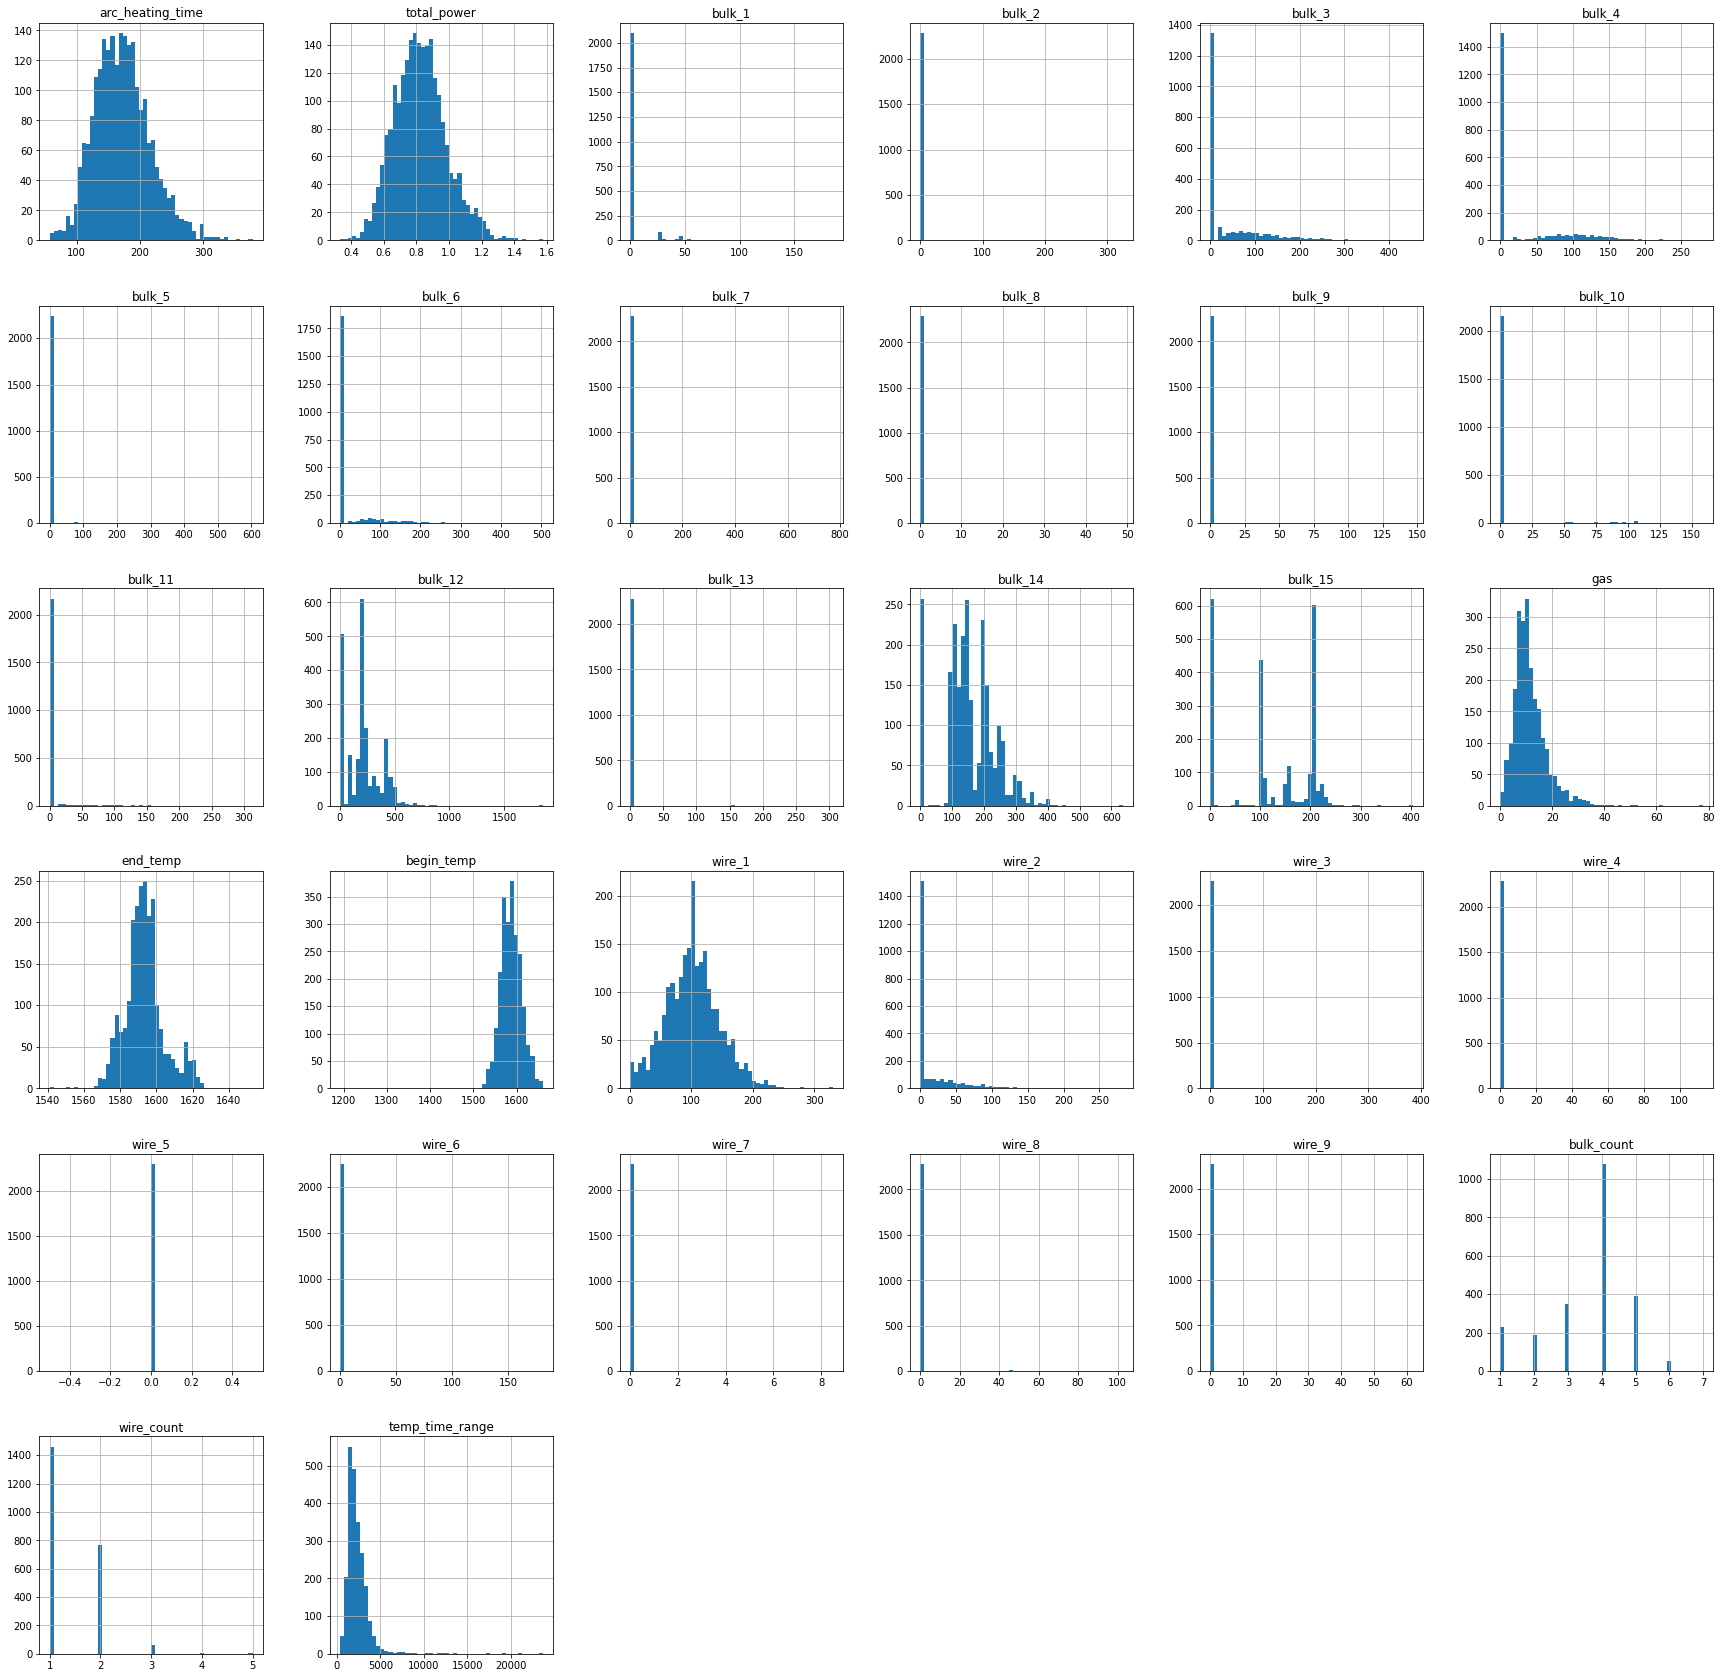

In [69]:
df.hist(bins=50,  grid=True, figsize=(30, 30));

Получены распределения по всему получившемуся датафрейму. arc_heatig_time, arc_power, gas и temperature имеют форму нормально распределения. Данные в столбцах bulk и wire имеют ярко выраженный пик в 0, поскольку мы заменяли отсутствующие значения нулями. Чем менеьше было пропущенных значений, тем больше распределение похоже на нормальное. Например, столбец wire_1. Проволоку именно этого состава чаще всего добавляют в сплав стали.

## Корреляционный анализ

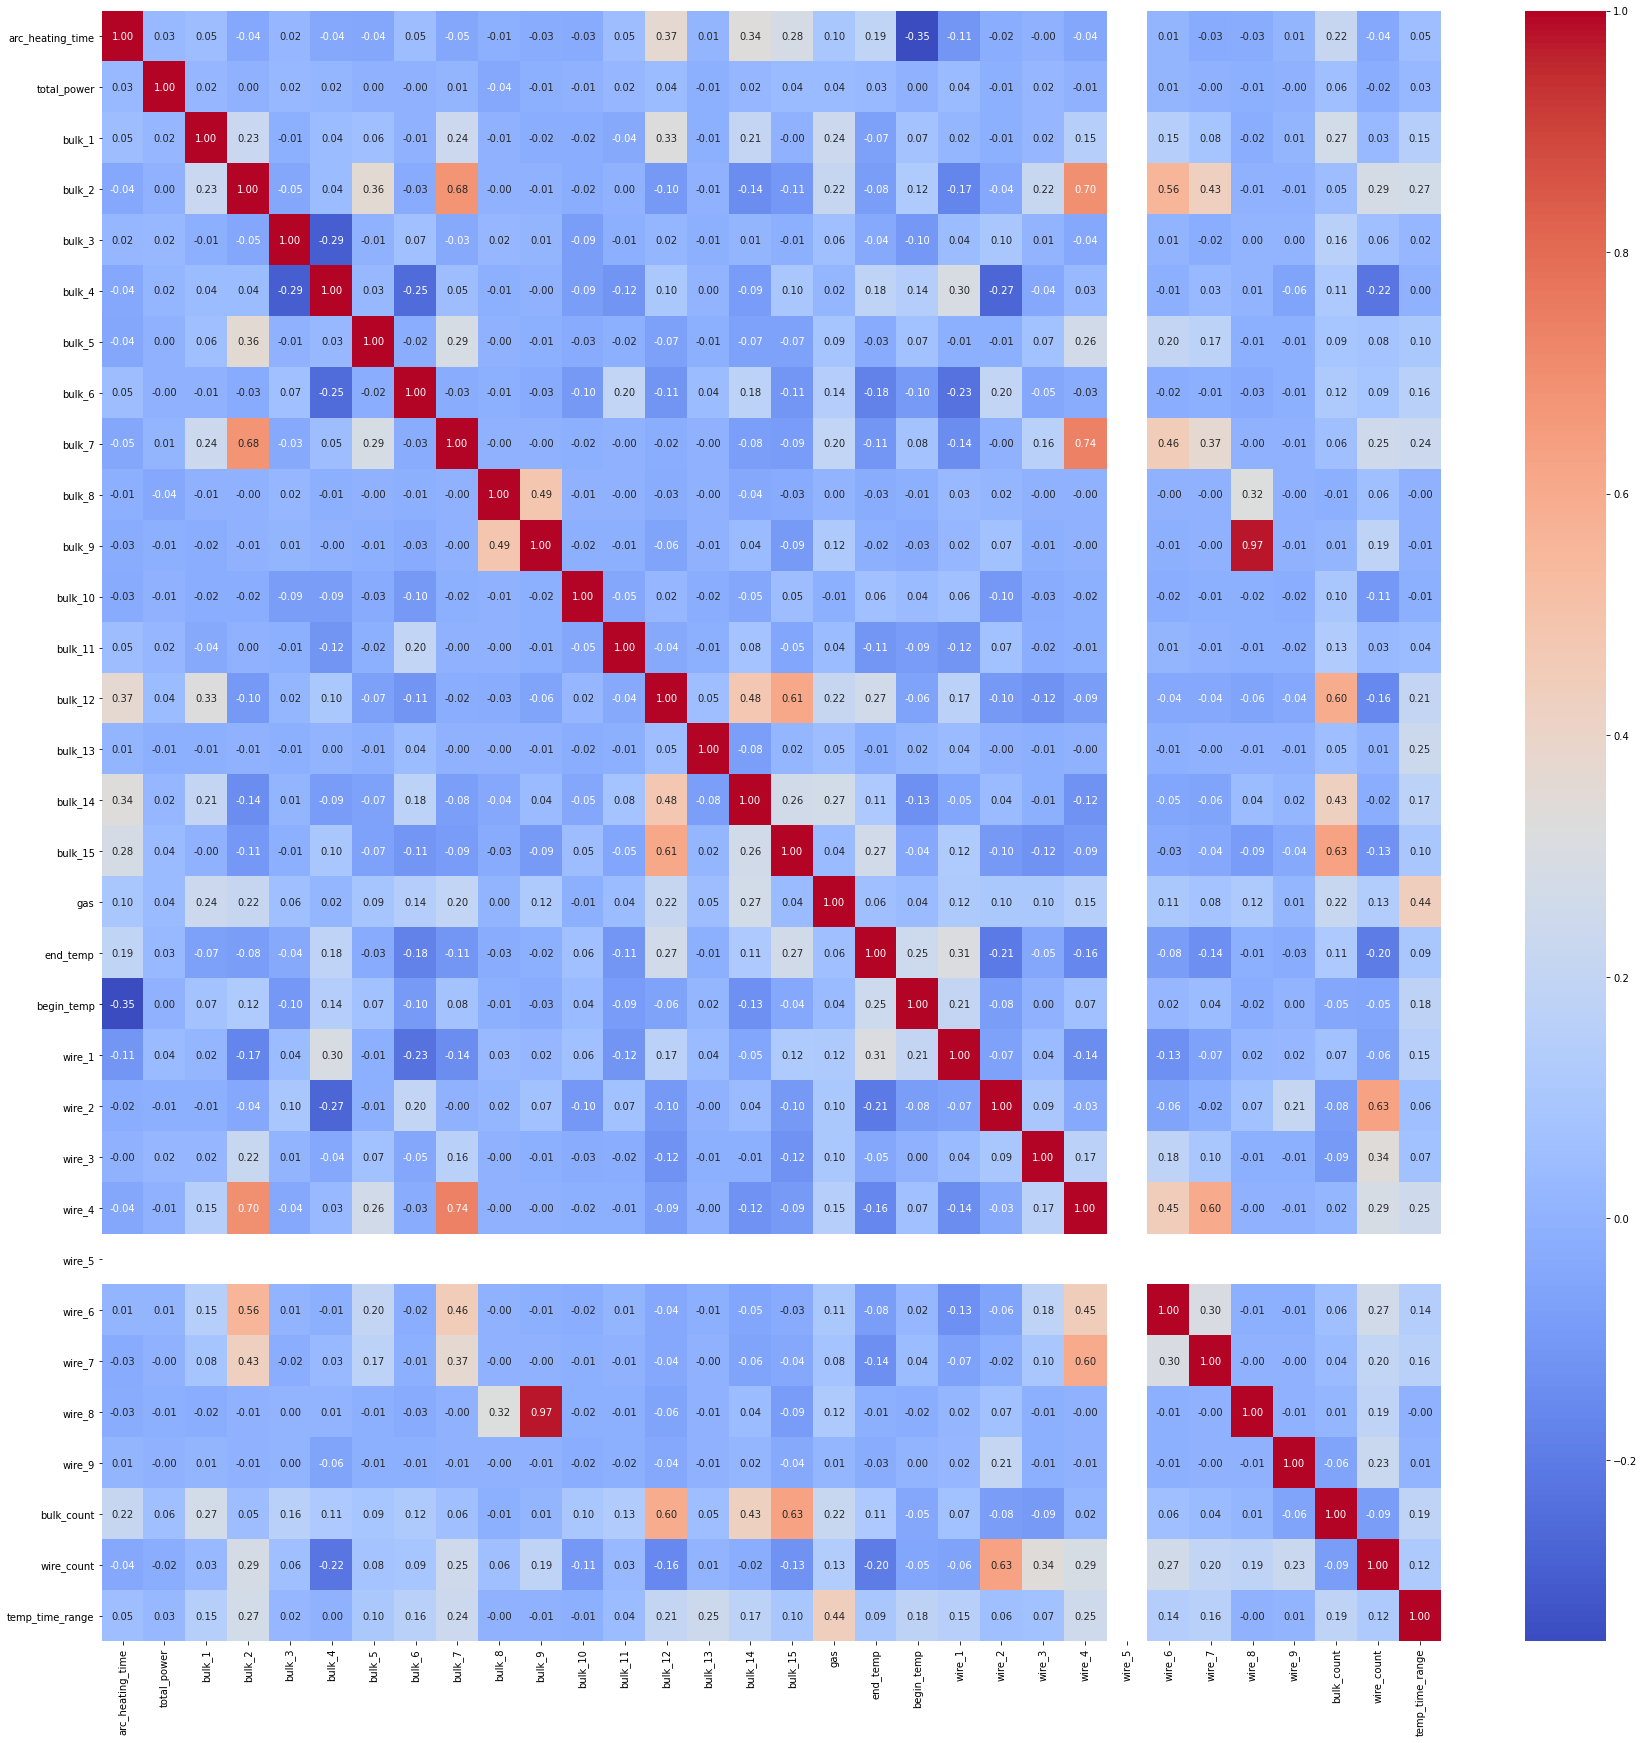

In [70]:
correlation_matrix = df.corr()

# Создаем тепловую карту матрицы корреляции
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Как видно из карты корреляции, у целевого признака мультиколлинеарность отсутствует, а коэффициент корреляции составляет в среднем 0.01 - 0.1. Тем не менее, можно заметить у некоторых признаков достаточно высокую корреляции. Например, у bulk_9 и wire_8 коэффициент корреляции близок к 1. Однако, это единичный случай и нет смысла удалять один из признаков из-за высокого коэффициента. В качестве линейной модели будем использовать модель регрессии Ridge с L2-регуляризацией

# Шаг 5. Подготовка данных

## Разделение на выборки

In [71]:
features = df.drop(['end_temp'], axis=1)
target = df['end_temp']

In [72]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=120424, test_size=0.25)

In [73]:
features_train.shape

(1719, 31)

## Масштабирование данных

In [74]:
scaler = StandardScaler()
scaler.fit(features_train)

# Масштабируем обучющую выборку
features_train_scaled = scaler.transform(features_train)
features_train_scaled = pd.DataFrame(features_train_scaled)
features_train_scaled.columns = features_train.columns

# Масштабируем тестовую выборку выборку
features_test_scaled = scaler.transform(features_test)
features_test_scaled = pd.DataFrame(features_test_scaled)
features_test_scaled.columns = features_test.columns

In [75]:
features_test_scaled

,arc_heating_time,total_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,begin_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,bulk_count,wire_count,temp_time_range
0,-0.101249,1.256013,-0.27358,-0.067946,0.695521,-0.634626,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,0.298388,-0.07707,-0.612073,1.008093,1.752488,1.504879,0.800766,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,-0.685215,2.488666
1,-0.344045,0.988789,-0.27358,-0.067946,-0.638393,0.293531,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,-0.017938,-0.07707,-0.096690,-0.196351,-0.052385,1.327547,2.616074,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,-0.685215,1.021750
2,-1.048396,1.633261,-0.27358,-0.067946,0.322025,-0.634626,4.290442,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,-0.346917,-0.07707,0.615029,-0.196351,1.823411,1.043815,1.182079,2.003300,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,1.142346,1.121356,0.795422
3,0.733870,-0.488630,-0.27358,-0.067946,0.442077,-0.634626,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,1.348591,-0.07707,0.725468,1.149793,-0.573881,-0.623108,-0.016052,0.395595,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,1.121356,-0.540054
4,-0.587383,0.935374,-0.27358,-0.067946,-0.638393,-0.634626,-0.109562,-0.392922,-0.064393,0.0,-0.075145,3.670545,-0.181363,-0.011612,-0.07707,-0.612073,0.972668,-0.095304,0.582751,0.970152,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,-0.685215,-0.329893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,0.895462,1.273339,-0.27358,-0.067946,-0.638393,-0.634626,-0.109562,1.969606,-0.064393,0.0,-0.075145,-0.244782,1.554514,0.298388,-0.07707,1.130411,-0.160926,0.251403,-1.651634,-0.217895,-0.513802,-0.113201,-0.060294,0.0,23.400281,-0.02856,-0.072606,-0.089832,1.142346,1.121356,-0.094427
570,0.587486,-0.445702,1.96114,-0.067946,-0.638393,1.407320,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,1.607978,-0.07707,1.289935,1.114368,0.176733,0.334486,1.307859,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,1.142346,-0.685215,-0.216026
571,0.721323,-1.289749,-0.27358,-0.067946,-0.638393,-0.634626,-0.109562,1.504260,-0.064393,0.0,-0.075145,-0.244782,-0.181363,0.292062,-0.07707,-0.354382,0.984477,-0.009600,-0.623108,-0.992455,1.092709,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,1.121356,0.588072
572,-0.705251,-0.734374,-0.27358,-0.067946,-0.638393,1.744832,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,0.652673,-0.07707,0.639571,-0.196351,-0.124232,-0.091111,1.991795,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,-0.685215,0.273883


In [76]:
features_train_scaled

,arc_heating_time,total_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,begin_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,bulk_count,wire_count,temp_time_range
0,-0.361155,-0.535034,-0.273580,-0.067946,-0.638393,2.402980,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,-0.036918,-0.07707,-0.231672,-0.196351,-0.763917,1.859543,0.851901,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,-0.685215,-0.185099
1,0.032370,0.088846,-0.273580,-0.067946,0.068581,-0.634626,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,-0.656917,-0.07707,-0.035335,-1.424412,-0.914320,1.079282,-0.440618,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,-0.487951,-0.685215,-0.408615
2,0.241489,0.480903,-0.273580,-0.067946,-0.638393,2.622362,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,0.450225,-0.07707,0.148730,0.429488,0.554982,0.689151,1.605084,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,-0.685215,0.115032
3,1.439172,-0.543498,-0.273580,-0.067946,-0.251558,-0.634626,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,1.032265,-0.07707,0.627300,1.055326,-0.256751,-0.623108,-0.400918,1.761513,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,1.121356,0.704047
4,-0.496131,0.272120,2.292209,-0.067946,-0.638393,0.496038,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,1.595325,-0.07707,-0.624344,-1.424412,1.311146,-1.296970,1.191739,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,-0.685215,-0.443057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,-0.801934,0.031791,1.961140,-0.067946,-0.638393,0.107900,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,1.924304,-0.07707,0.860449,0.972668,0.037631,-0.587641,1.432501,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,1.142346,-0.685215,-0.313726
1715,-0.553164,0.292446,-0.273580,-0.067946,4.083661,-0.634626,-0.109562,1.665341,-0.064393,0.0,-0.075145,-0.244782,-0.181363,-0.017938,-0.07707,-0.170317,-0.184543,0.074733,0.121688,0.304326,0.064822,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,1.142346,1.121356,-0.275771
1716,1.754752,-0.033181,-0.273580,-0.067946,0.348703,-0.634626,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,-0.024265,-0.07707,-0.624344,0.972668,-1.331359,-0.694041,-0.670302,-0.513802,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,0.327197,-0.685215,-0.163310
1717,-0.963798,-0.505581,-0.273580,-0.067946,-0.638393,-0.634626,-0.109562,-0.392922,-0.064393,0.0,-0.075145,-0.244782,-0.181363,0.292062,-0.07707,-0.047606,1.008093,-1.215505,0.972882,-0.857941,0.851204,-0.113201,-0.060294,0.0,-0.105735,-0.02856,-0.072606,-0.089832,-0.487951,1.121356,-0.739673


В ходе подготовки данных для обучения моделей, разделили весь датасет на признаки и целевой признак. Далее выделили тестовую и обучающие выборки. Обучающую выборку масштабировали для более качественного обучения моделей.

# Шаг 6. Обучение моделей

## Ridge

In [77]:
params_grid_ridge = {
    'alpha': [1, 2, 3]
}

In [78]:
model_ridge = Ridge()
GS_ridge = GridSearchCV(estimator = model_ridge,
                        param_grid = params_grid_ridge,
                        scoring = 'neg_mean_absolute_error',
                        cv=5) 

In [79]:
%%time
GS_ridge.fit(features_train_scaled, target_train)

CPU times: user 421 ms, sys: 557 ms, total: 978 ms
Wall time: 933 ms


GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [1, 2, 3]},
             scoring='neg_mean_absolute_error')

In [80]:
GS_ridge.best_params_

{'alpha': 3}

In [81]:
mae_ridge = -GS_ridge.best_score_
mae_ridge

7.404318301257826

## Random Forest

In [87]:
param_grid_rf = {
    "n_estimators": randint(10, 100),
    "max_depth": randint(1, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "bootstrap": [True, False]}

In [88]:
model_rf = RandomForestRegressor(random_state=120424)
RS_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grid_rf,
    n_iter=50,  
    cv=5, 
    scoring='neg_mean_absolute_error',
    random_state=120424)

In [89]:
%%time
RS_rf.fit(features_train_scaled, target_train)

CPU times: user 1min 18s, sys: 88.7 ms, total: 1min 18s
Wall time: 1min 18s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=120424),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4152e1f250>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f41505650d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4150549df0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4150549460>},
                   random_state=120424, scoring='neg_mean_absolute_error')

In [90]:
RS_rf.best_params_

{'bootstrap': True,
 'max_depth': 13,
 'min_samples_leaf': 2,
 'min_samples_split': 9,
 'n_estimators': 56}

In [91]:
mae_rf = -RS_rf.best_score_
mae_rf

6.7639556812739245

## LightGBM

In [87]:
params_grid_lgb = {
    'num_leaves': randint(10, 100),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': randint(50, 150)
}

In [88]:
model_lgb = LGBMRegressor(random_state=120424)

In [89]:
RS_lgb = RandomizedSearchCV(estimator = model_lgb,
                     param_distributions = params_grid_lgb,
                     scoring = 'neg_mean_absolute_error',
                     cv=5, verbose=2, n_iter=50, random_state=120424)  

In [90]:
RS_lgb.fit(features_train_scaled, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   2.3s
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   1.8s
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   1.5s
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   1.8s
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   2.0s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   2.8s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   3.0s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   2.8s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   2.6s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   3.1s
[CV] END .learning_rate=0.1, n_estimators=120, num_leaves=33; total time=   2.5s
[CV] END .learning_rate=0.1, n_estimators=120, 

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=120424),
                   n_iter=50,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbce0a00340>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbcec887fa0>},
                   random_state=120424, scoring='neg_mean_absolute_error',
                   verbose=2)

In [91]:
RS_lgb.best_params_

{'learning_rate': 0.1, 'n_estimators': 58, 'num_leaves': 22}

In [92]:
mae_lgb = -RS_lgb.best_score_
mae_lgb

6.736837836129341

## CatBoost

In [93]:
model_cat = CatBoostRegressor(random_state=120424)

In [94]:
params_grid_cat = {
    'learning_rate': [0.01, 0.1],
    'depth': [5, 10, 15, 20],
    'iterations': [25, 50, 75]
}

In [95]:
GS_cat = GridSearchCV(
    estimator=model_cat, 
    param_grid=params_grid_cat, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=2
)

In [96]:
GS_cat.fit(features_train_scaled, target_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0:	learn: 11.3343271	total: 49.4ms	remaining: 1.19s
1:	learn: 11.3149733	total: 51.5ms	remaining: 592ms
2:	learn: 11.2922603	total: 53.5ms	remaining: 393ms
3:	learn: 11.2736312	total: 55.6ms	remaining: 292ms
4:	learn: 11.2515727	total: 57.4ms	remaining: 229ms
5:	learn: 11.2305406	total: 59.3ms	remaining: 188ms
6:	learn: 11.2105216	total: 61.1ms	remaining: 157ms
7:	learn: 11.1886598	total: 63.1ms	remaining: 134ms
8:	learn: 11.1654281	total: 65.3ms	remaining: 116ms
9:	learn: 11.1437095	total: 67.1ms	remaining: 101ms
10:	learn: 11.1215061	total: 69.2ms	remaining: 88.1ms
11:	learn: 11.1021974	total: 71.1ms	remaining: 77ms
12:	learn: 11.0798518	total: 73.1ms	remaining: 67.4ms
13:	learn: 11.0606057	total: 74.9ms	remaining: 58.9ms
14:	learn: 11.0418409	total: 76.8ms	remaining: 51.2ms
15:	learn: 11.0205615	total: 78.7ms	remaining: 44.3ms
16:	learn: 11.0001601	total: 80.5ms	remaining: 37.9ms
17:	learn: 10.9774405	total: 82.5ms	remain

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fbce0cfa730>,
             param_grid={'depth': [5, 10, 15, 20], 'iterations': [25, 50, 75],
                         'learning_rate': [0.01, 0.1]},
             scoring='neg_mean_absolute_error', verbose=2)

In [97]:
GS_cat.best_params_

{'depth': 5, 'iterations': 75, 'learning_rate': 0.1}

In [98]:
mae_cat = -GS_cat.best_score_
mae_cat

6.756126607060044

## Выбор лучшей модели

In [99]:
models_info = [['Ridge', mae_ridge],
            ['RandomForestRegression', mae_rf],
            ['LightGBM', mae_lgb],
            ['CatBoost', mae_cat]]

In [100]:
pd.DataFrame(models_info, columns=["Model","MAE"])

,Model,MAE
0,Ridge,7.404318
1,RandomForestRegression,6.763956
2,LightGBM,6.736838
3,CatBoost,6.756127


Построили 4 модели машинного обучения: Ridge, RandomForest, LightGBM и CatBoost. Наилучшее значение метрики MAE показала модель LightGBM.

# Шаг 7. Проверка качества лучшей модели

## Предсказание модели на тестовой выборке

In [101]:
RS_lgb.fit(features_train_scaled, target_train)
predictions_test = RS_lgb.predict(features_test_scaled)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   1.5s
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   1.6s
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   1.7s
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   2.0s
[CV] END learning_rate=0.001, n_estimators=91, num_leaves=35; total time=   2.4s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   2.9s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   2.3s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   3.2s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   2.9s
[CV] END ..learning_rate=0.1, n_estimators=99, num_leaves=66; total time=   3.1s
[CV] END .learning_rate=0.1, n_estimators=120, num_leaves=33; total time=   2.0s
[CV] END .learning_rate=0.1, n_estimators=120, 

In [102]:
mae_test = mean_absolute_error(predictions_test, target_test)
round(mae_test, 2)

6.53

На тестовой выборке модель показала хорошее значение метрики MAE, равное 6.53. Значение меньше порогового 6.8 градуса.

## Оценка модели на адекватность

In [103]:
model_dr = DummyRegressor(strategy="mean")
model_dr.fit(features_train_scaled, target_train)
predictions = model_dr.predict(features_test)
mae_dummy = mean_absolute_error(target_test, predictions)
mae_dummy

8.071209661236479

MAE нашей модели лучше, чем у константной модели.

# Шаг 8. Исследование важности признаков

In [104]:
model = RS_lgb.best_estimator_
model.fit(features_train_scaled, target_train)

LGBMRegressor(n_estimators=58, num_leaves=22, random_state=120424)

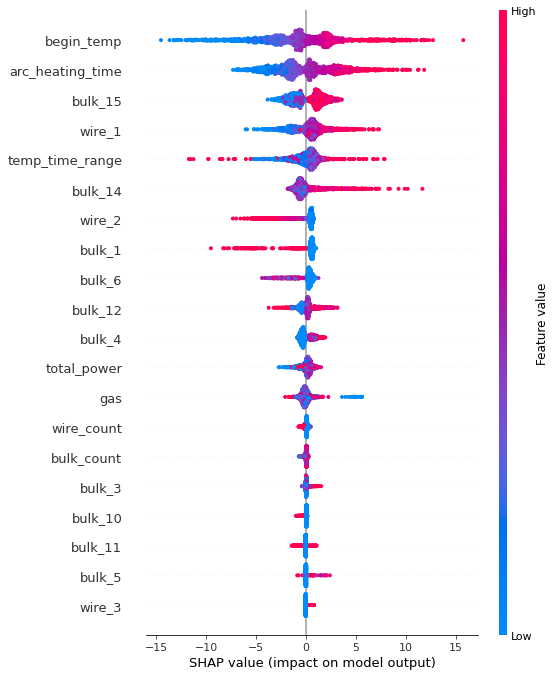

In [105]:
explainer = shap.Explainer(model, features_train_scaled)

shap_values = explainer(features_train_scaled)

shap.summary_plot(shap_values, features_train_scaled)

Построили график, показывающий вклад каждого признака на предсказание целевого признака. Наибольшее значение оказывает начальная температура сплава. При её увеличении, также и увеличится предсказанная конечная температура. На втором месте, расположилось время нагрева дугой, а тройку лидеров закрывает bulk_15.

# Шаг 9. Общий вывод

Задача проекта звучала следующим образом: построить модель для предсказания температуры сплава для оптимизации потребления электроэнергии.
В ходе работы на проектом выполнены следующие мероприятия:
- Загружены и проанализированы данные по всем 7 датасетам.
- Проведен EDA каждого датасета по отдельности, где были преобразованы данные в нужные форматы, построены boxplots и графики распределения для численных значений. Сделаны выводы об имеющихся признаках, по результатам которых решено не использовать время добавления сыпучих материалов и проволоки в сплав. 
- Все оставшиеся датасеты объединены в один по общему столбцу key.
- Проведен EDA для общего датасета. Сгенерированы новые признаки: общая мощность, разнообразие сыпучих материалов и проволок различного состава, время нагрева каждого ковша до оптимальной температуры. Удалили ненужные столбцы. Названия столбцов приведены к нижнему змеиному регистру. Удалены столбцы с пропусками в связи с невозможностью замены пропусков, а также удалены ковши без целевого признака. Визуализированы признаки и построена тепловая карта корреляции признаков.
- Обучены 4 разные модели (Ridge, RandomForest, LightGBM и CatBoost), подобраны оптимальные гиперпараметры. Выбрана наилучшая модель по точности предсказания оптимальной температуры. Ей оказалась модель LightGBM.
- При проверке качества модели на тестовой выборке метрика MAE составила 6.53 градусов, что входит в пределы порогового значения 6.8. Построенная модель показала лучший результат метрики MAE, чем константная Dummy модель.
- Исследованы важности признаков: наибольший вклад в предсказание оптимальной температуры сплава оказала начальная температура сплава, bulk_15 и время нагрева электрической дуги. 